In [127]:
# Import all and only the necessary libraries (covered in the lectures, no others required). 
import pandas as pd
import numpy as np
import csv
from sklearn.tree import DecisionTreeClassifier 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

#Load the dataset into a Pandas DataFrame using the following column names
# 'ID, 'senior', 'tenure', 'streaming', 'contract', 'payMethod',
#'monthlyCharges', 'totalCharges', 'churn'

columns = ['ID', 'senior', 'tenure', 'streaming', 'contract', 'payMethod',
'monthlyCharges', 'totalCharges', 'churn']

df = pd.read_csv("CustomerChurn.csv", names = columns)

In [128]:
df.head(5)
df.shape
df.dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              7043 non-null   object 
 1   senior          7040 non-null   float64
 2   tenure          7021 non-null   float64
 3   streaming       7042 non-null   object 
 4   contract        7041 non-null   object 
 5   payMethod       7042 non-null   object 
 6   monthlyCharges  7041 non-null   float64
 7   totalCharges    7042 non-null   object 
 8   churn           7043 non-null   object 
dtypes: float64(3), object(6)
memory usage: 495.3+ KB


In [129]:
# initial check to see the sum of null values in each feature
df.isna().sum()

ID                 0
senior             3
tenure            22
streaming          1
contract           2
payMethod          1
monthlyCharges     2
totalCharges       1
churn              0
dtype: int64

In [130]:
df['totalCharges'] = pd.to_numeric(df['totalCharges'], errors='coerce')

In [131]:
df['totalCharges'].dtypes 

dtype('float64')

In [132]:
df['totalCharges'].isnull().sum()

12

In [133]:
df["totalCharges"].fillna(df["totalCharges"].mean(), inplace = True)

In [134]:
df['totalCharges'].isnull().sum()

0

In [135]:
# checking for null values across rows that host more than two Nans using one of the features 
df[df["senior"].isna()]

,ID,senior,tenure,streaming,contract,payMethod,monthlyCharges,totalCharges,churn
5,9305-CDSKC,NaN,NaN,Yes,NaN,NaN,99.65,2283.508491,Yes
7038,6840-RESVB,NaN,NaN,NaN,One year,Mailed check,NaN,1990.500000,No
7042,3186-AJIEK,NaN,NaN,Yes,NaN,Bank transfer (automatic),NaN,6844.500000,No


In [136]:
# this drops each row with many null values 
df = df.drop(df[df["senior"].isna()].index)

In [137]:
# ensure that all rows which contain multiple null values have been dropped
df.isna().sum()

ID                 0
senior             0
tenure            19
streaming          0
contract           0
payMethod          0
monthlyCharges     0
totalCharges       0
churn              0
dtype: int64

In [138]:
# very few rows with multiple missing values, hence why I chose to drop them rather than fill them 
# as they would not make a substantial difference to the prediction 

In [139]:
# running mean on tenure feature
df["tenure"].fillna(df["tenure"].mean(), inplace = True)

In [140]:
# verify that now all features are non-null 
df.isna().sum()

ID                0
senior            0
tenure            0
streaming         0
contract          0
payMethod         0
monthlyCharges    0
totalCharges      0
churn             0
dtype: int64

In [141]:
# i chose imputation via mean for tenure as it is a datatype that contains numerical value and to not make it deviate much

In [142]:
# dropping the ID column as it has no impact on consumer expenditure 
df.drop(columns=["ID"], inplace = True)

In [143]:

enc = OneHotEncoder(handle_unknown="ignore", sparse_output = False) # ignore unknown values and sparse output false because we require dense matrix for later use 
enc_values = enc.fit_transform(df[["streaming","contract","payMethod", "churn"]])


In [144]:
enc_values

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 1.]])

In [145]:
enc.categories_

[array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array(['Bank transfer (automatic)', 'Credit card (automatic)',
        'Electronic check', 'Mailed check'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

In [146]:
# replacing values in features with ones that are identical or similar to them so as to avoid creating many columns when one hot encoding
# this is done to dodge dimensionality curse 

In [147]:
# converting "no internet service" to "no" means one less feature in the df to deal with
df["streaming"].replace({"No internet service":"No"}, inplace=True)

In [148]:
# checking to see if the above logic has been successful by counting the UPDATED value count for each value in the respective feature
df["streaming"].value_counts()

streaming
No     4311
Yes    2729
Name: count, dtype: int64

In [149]:
# since both automatic transactions are very similar in nature, they are converted to "Automatic"; again, one less feature in the df to deal with
df["payMethod"].replace({"Bank transfer (automatic)":"Automatic payment", "Credit card (automatic)":"Automatic payment" },inplace=True)

In [150]:
# checking to see if the above logic has been successful by counting the UPDATED value count for each value in the respective feature
df["payMethod"].value_counts()

payMethod
Automatic payment    3065
Electronic check     2364
Mailed check         1611
Name: count, dtype: int64

In [151]:
df["churn"].value_counts()

churn
No     5172
Yes    1868
Name: count, dtype: int64

In [152]:
df["Not streamed"]=enc_values[:, 0]
df["Streamed"]=enc_values[:, 1]
df["Mailed check"]=enc_values[:, 0]
df["Electronic check"]=enc_values[:, 1]
df["Automatic Payment"]=enc_values[:, 2]
df["Month-to-month contract"]=enc_values[:, 0]
df["One year contract"]=enc_values[:, 1]
df["Two year contract"]=enc_values[:, 2]
df["Churned"]=enc_values[:, 0]
df["Not churned"]=enc_values[:, 1]

In [153]:
# dropping features after transforming their categorical values into numeric as our input data can not be computer readable if left in categorical format
df = df.drop(columns = ['streaming', 'payMethod', 'contract', 'churn'])

In [154]:
df.head(3)

,senior,tenure,monthlyCharges,totalCharges,Not streamed,Streamed,Mailed check,Electronic check,Automatic Payment,Month-to-month contract,One year contract,Two year contract,Churned,Not churned
0,0.0,1.0,29.85,29.85,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,34.0,56.95,1889.50,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,2.0,53.85,108.15,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [155]:
# Split into training and testing sets
X = df[['senior','tenure','monthlyCharges','Not streamed','Streamed','Mailed check','Electronic check','Automatic Payment','Month-to-month contract',
        'One year contract','Two year contract','Churned','Not churned']]
y = df['totalCharges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)

# Display the shape of the data
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (5632, 13)
Testing set shape: (1408, 13)


In [156]:
# ensuring train set is 80% by checking its length 
len(X_train)

5632

In [157]:
# ensuring test set is 20% by checking its length 
len(X_test)

1408

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7040 entries, 0 to 7041
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   senior                   7040 non-null   float64
 1   tenure                   7040 non-null   float64
 2   monthlyCharges           7040 non-null   float64
 3   totalCharges             7040 non-null   float64
 4   Not streamed             7040 non-null   float64
 5   Streamed                 7040 non-null   float64
 6   Mailed check             7040 non-null   float64
 7   Electronic check         7040 non-null   float64
 8   Automatic Payment        7040 non-null   float64
 9   Month-to-month contract  7040 non-null   float64
 10  One year contract        7040 non-null   float64
 11  Two year contract        7040 non-null   float64
 12  Churned                  7040 non-null   float64
 13  Not churned              7040 non-null   float64
dtypes: float64(14)
memory usage: 

In [165]:
# model building
# fit() for training data and predict() for testing data
# output(totalCharges) is continuous therefore linear regression to be imported

from sklearn.tree import DecisionTreeRegressor 

tree_regressor = linear_model.LinearRegression()
tree_regressor.fit(X, y)

LinearRegression()

In [169]:
#score of model
DTscore = tree_regressor.score(X,y)
DTscore

0.8924412390561813

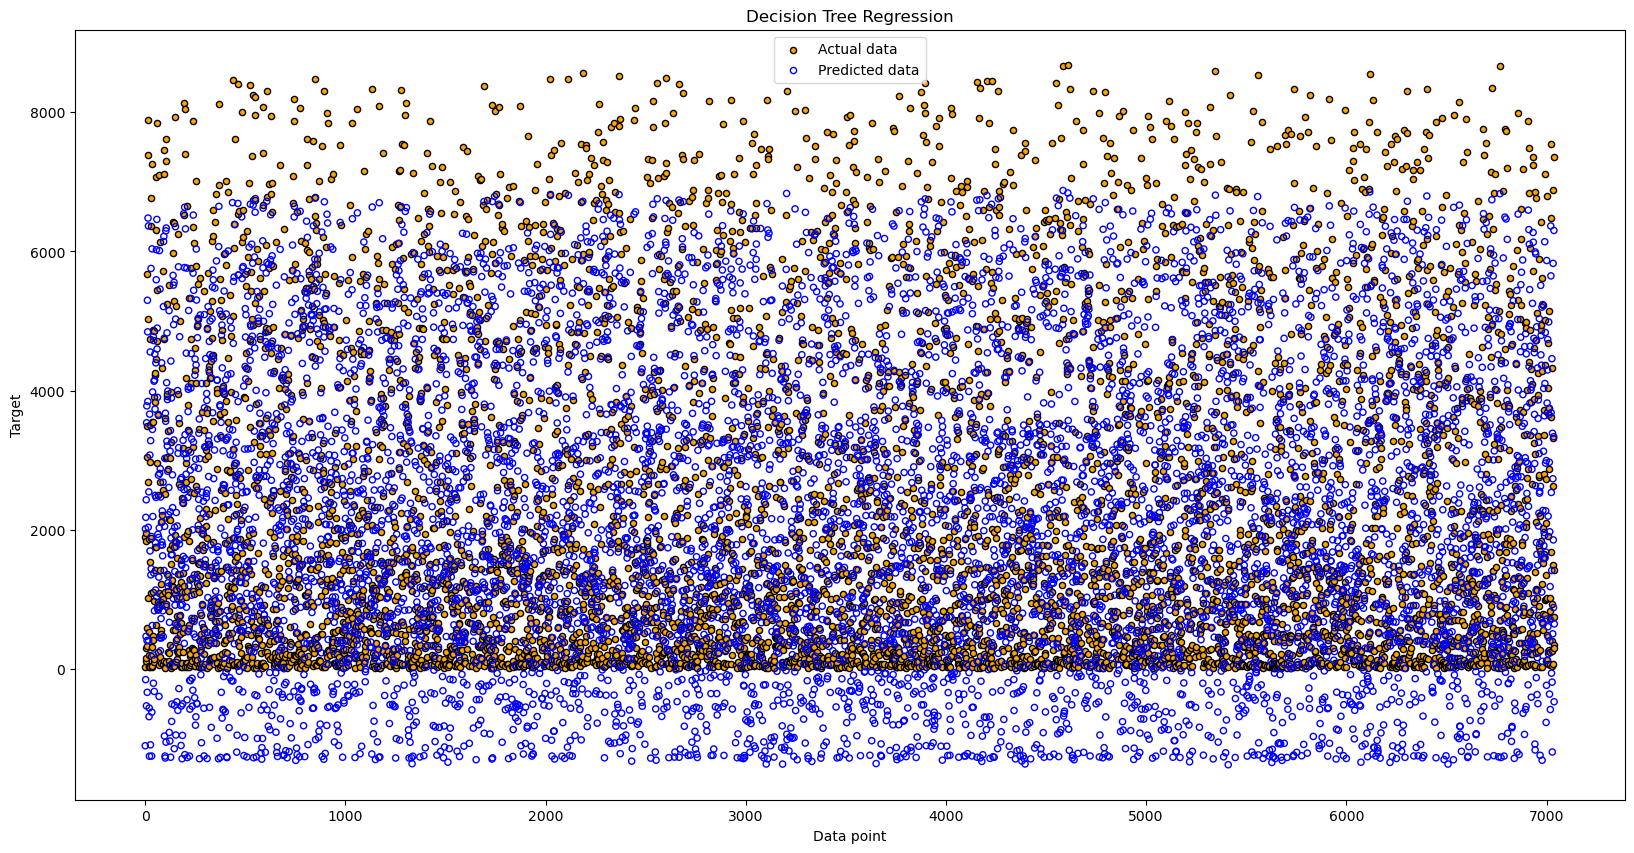

In [174]:
# visualising quality of model 

import matplotlib.pyplot as plt
# predictions from data
y_pred = tree_regressor.predict(X)

# data point indices
indicies = np.arange(len(y))

plt.figure(figsize=(20,10))

plt.scatter(indicies, y, s=20, edgecolor="black", c="orange", label="Actual data")
plt.scatter(indicies, y_pred, s=20, edgecolor="blue", c="none", label="Predicted data")

plt.xlabel("Data point")
plt.ylabel("Target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [172]:
r_squared = tree_regressor.score(X_test,y_test)
r_squared

In [ ]:
# trained data score is 0.8924412390561813
# test data/unseen score is 0.8991634098236898
'''
observation- score for train and test are both high therefore this is a good sign that this data is not 
overfitted(high score of training data + low score of test data) or underfitted(low score of training AND test data)
'''

In [176]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping



# Normalising numeric data 
# StandardScaler 
scaler = StandardScaler()
# Fit scaler on training features and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)






In [177]:
# Build the ANN (feedforward) 
tf.random.set_seed(12)  # reproducibility
input_dim = X_train_scaled.shape[1]

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),   # hidden layer 1
    Dense(32, activation='relu'),                            # hidden layer 2
    Dense(1, activation='linear')                            # output layer for regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

/home/057b8779-ec30-419d-ae91-b02a3c902225/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-05 11:59:47.993992: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
# Train the model 
# EarlyStopping prevents overfitting 
early_stop = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,   # part of training set for validation
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

In [ ]:
if ann_r2 > r_squared:
    print("ANN outperforms the Decision Tree (higher R^2).")
 else:
   print("ANN did not outperform the Decision Tree. Consider tuning architecture, regularization, or training.")

In [ ]:
# Plot training history (loss curve) 
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train loss (MSE)')
plt.plot(history.history['val_loss'], label='val loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('ANN training history (MSE)')
plt.legend()
plt.grid(True)
plt.show()